In [1]:
# Plot a surface map with mean sea level pressure (MSLP), 2m temperature (deg C), and wind barbs (kt).

# coding: utf-8

# Imports
import os
import time
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Any import of metpy will activate the accessors
import metpy.calc as mpcalc
from metpy.testing import get_test_data
from metpy.units import units

In [2]:
# Change the current working directory
os.chdir("/Users/tomokokoyama/Data/temp" )
cwd = os.getcwd()

### Download a GRIB file ###

# Specify our date/time of product desired (in UTC)
time = pd.Timestamp(2020, 8, 1, 6, 0)

day_dir = time.strftime("%Y/%m/%d")
ftime = time.strftime("%Y%m%d%H%M%S")

# Access JMA NWP data 
#      – NOT for commercial use! –
#      Kyoto University RISH Data Server (via the Japan Meteorological Business Support Center)
#      Documentation: http://www.jmbsc.or.jp/jp/online/file/F_filelist.pdf 
url_rish = "http://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/original"

header = "Z__C_RJTD_"
kind   = "_GSM_GPV_Rjp_Lsurf_FD0000-0312_grib2"         # Global Spectral Model (GSM) output over Japan at the surface level 
ext    = ".bin"

# Assemble the name of the grib file to retrieve
target = os.path.join(url_rish, day_dir, "{}{}{}{}".format(header, ftime, kind, ext))
fname = os.path.basename(target)

# Obtain the data
fgrib = os.path.join(cwd, fname)
if os.path.exists(fgrib):
    print('Already exist: ',fgrib)
else:
    subprocess.run(['curl', '-O', target], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, cwd=cwd)

Already exist:  /Users/tomokokoyama/Data/temp/Z__C_RJTD_20200801060000_GSM_GPV_Rjp_Lsurf_FD0000-0312_grib2.bin


In [3]:
# Open the GRIB file
grbs = pygrib.open(fgrib)

#for grb in grbs:
#    print(grb)

In [4]:
# Pull out variables at the initial time
p0 = grbs.select(name='Pressure reduced to MSL')[0]
t0 = grbs.select(name='2 metre temperature')[0]
u0 = grbs.select(name='10 metre U wind component')[0]
v0 = grbs.select(name='10 metre V wind component')[0]

mslp = p0.values*units('Pa')
temp = t0.values*units('K')
u_wind = u0.values*units('m/s')
v_wind = v0.values*units('m/s')

# Convert winds to knots
u_wind.ito('kt')
v_wind.ito('kt')

#plt.imshow(mslp)

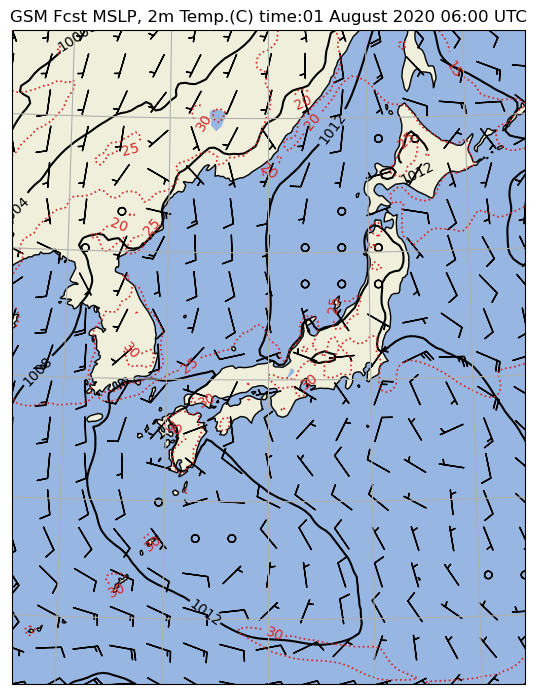

In [5]:
# Get the latitudes and longitudes of the grid:
lats, lons = p0.latlons()

# Set projection of map display
map_crs = ccrs.LambertConformal(central_longitude = 135, 
                                central_latitude = 35,
                                standard_parallels = (10, 10))

# Set projection of data
data_crs = ccrs.PlateCarree()

# Create a new figure and plot data
fig = plt.figure(1, figsize=(11, 8.5))

# Add the map and set the extent
ax = plt.subplot(1, 1, 1, projection=map_crs)
ax.set_extent([123, 147, 22, 48], data_crs)

plt.title('GSM Fcst MSLP, 2m Temp.(C) time:'+
          time.strftime("%d %B %Y %H:%M UTC"), fontsize=12)

# Add geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.LAND)

ax.gridlines()

# Plot MSLP contours
clev_mslp = np.arange(800, 1200, 4)
cs = ax.contour(lons, lats, mslp.to(units('hPa')), levels=clev_mslp, 
               transform=data_crs, colors='black')
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot 2m temperature contours
clevtemp = np.arange(-60, 60, 5)
cs2 = ax.contour(lons, lats, temp.to(units('degC')), clevtemp,
                 colors='tab:red', linewidths=1.25, linestyles='dotted',
                 transform=data_crs)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot 10m wind barbs
ax.barbs(lons, lats, u_wind.magnitude, v_wind.magnitude,
         length=6, regrid_shape=15, pivot='middle', transform=data_crs)
